In [20]:
import numpy as np
import halotools
import matplotlib.pyplot as plt
import scipy.optimize as opt

from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.sim_manager import CachedHaloCatalog

# load array of DM halos from Bolshoi n-body simulation
bolshoi_z0 = CachedHaloCatalog()
bolshoi_m200b = np.array(bolshoi_z0.halo_table['halo_m200b'])

In [21]:
# functions for computing curves with fixed galaxy number density in HOD space

'''
Takes as input a halotools PrebuiltHodModelFactory object 'hod', an array 'halos' of halo masses,
and the linear size of the simulation 'sim_size' in Mpc/h.

Returns the mean galaxy number density of those halos populated by that HOD in (Mpc/h)^(-3).
'''
def gal_density(hod, halos, sim_size):
    cens = hod.mean_occupation_centrals(prim_haloprop = halos)
    sats = hod.mean_occupation_satellites(prim_haloprop = halos)
    return np.sum(cens + sats) / (sim_size ** 3)    # galaxy number density in (h^{-1} Mpc)^{-3}

'''
Helper function for param2_root(). Takes same arguments as gal_density() plus a float 'density'
specifying a desired galaxy number density in (Mpc/h)^(-3), a string 'param' specifying a
halotools HOD parameter to set, and a float 'param_val' giving the value to which that parameter
should be set.

Returns the difference between desired density and actual density given by HOD.
'''
def density_err(hod, halos, sim_size, density, param, param_val):
    old_param = hod.param_dict[param]
    hod.param_dict[param] = param_val
    result = density - gal_density(hod, halos, sim_size)
    hod.param_dict[param] = old_param
    return result

'''
Helper function for isodensity_curve(). Takes same arguments as density_err() plus a second string
'param2' specifying a second halotools HOD parameter which can vary over the range specified by the
2-element list 'param2_bracket'. Also takes a float 'rel_prec' which sets the relative tolerance for
root-finding in opt.root_scalar using the brentq method.

For the given value of param1, returns the value of param2 which achieves desired density.
'''
def param2_root(hod, halos, sim_size, density, param1, param1_val, param2, param2_bracket, rel_prec):
    old_param1 = hod.param_dict[param1]
    hod.param_dict[param1] = param1_val
    temp_density_err = lambda x : density_err(hod, halos, sim_size, density, param2, x)
    result = opt.root_scalar(temp_density_err, method='brentq', bracket=param2_bracket, rtol=rel_prec).root
    hod.param_dict[param1] = old_param1
    return result

'''
Takes halotools PrebuiltHodModelFactory objects 'hod', array of halo masses 'halos', simulation linear
size 'sim_size' in Mpc/h, an int 'num_pts' giving number of points to find on curve, string 'param1'
specifying parameter to iterate over, 2-element list 'param1_range' for that parameter, string 'param2'
specifying parameter to vary in fitting galaxy density 'density' in (Mpc/h)^(-3), and float 'rel_prec'
giving relative precision for root-finding in the helper funciton param2_root.

Returns numpy arrays containing ordered values of param1, param2 along constant-density curve.
'''
def isodensity_curve(hod, halos, sim_size, num_pts, param1, param1_range, param2, density, rel_prec=0.001):
    param1_min, param1_max = param1_range[0], param1_range[1]
    
    bound_a = param2_root(hod, halos, sim_size, density, param1, param1_min, param2, [0,20], rel_prec)
    bound_b = param2_root(hod, halos, sim_size, density, param1, param1_max, param2, [0,20], rel_prec)
    
    param2_bracket = [0.9 * min(bound_a, bound_b), 1.1 * max(bound_a, bound_b)]
    
    param1_values = np.linspace(param1_min, param1_max, num_pts)
    
    root_function = lambda x : param2_root(hod, halos, sim_size, density, param1, x, param2, param2_bracket, rel_prec)
    
    param2_values = np.vectorize(root_function)(param1_values)
    
    return param1_values, param2_values

In [108]:
# generate isodensity curve with given settings

some_hod = PrebuiltHodModelFactory('zheng07')
# see Coupon et al. 2018 Table B1, 0.2 < z < 0.4, M_g-5logh < -20.8 for fiducial HOD params
some_hod.param_dict['logM1'] = 13.69
some_hod.param_dict['logMmin'] = 12.36
some_hod.param_dict['logM0'] = 8.35
some_hod.param_dict['sigma_logM'] = 0.32
some_hod.param_dict['alpha'] = 1.28

kwargs = {'hod' : some_hod,
          'halos' : bolshoi_m200b,
          'sim_size' : 250,
          'num_pts' : 100,
          'param1' : 'logM1',
          'param1_range' : [13.515, 16],
          'param2' : 'logMmin',
          'density' : 0.001,
          'rel_prec' : 10**(-6)}

logM1_values, logMmin_values = isodensity_curve(**kwargs)

In [113]:
np.save('logM1_array_100_gap=2.5_r=5.0.npy', logM1_values)
np.save('logMmin_array_100_gap=2.5_r=5.0.npy', logMmin_values)

In [109]:
# validate by reproducing galaxy number densities for points along iso-density curve

validation_hod = PrebuiltHodModelFactory('zheng07')
validation_hod.param_dict['logM1'] = 13.69
validation_hod.param_dict['logMmin'] = 12.36
validation_hod.param_dict['logM0'] = 8.35
validation_hod.param_dict['sigma_logM'] = 0.32
validation_hod.param_dict['alpha'] = 1.28

validation_n_gal = []

for i in range(len(logM1_values)):
    validation_hod.param_dict['logM1'] = logM1_values[i]
    validation_hod.param_dict['logMmin'] = logMmin_values[i]
    
    cens_array = validation_hod.mean_occupation_centrals(prim_haloprop = bolshoi_m200b)
    sats_array = validation_hod.mean_occupation_satellites(prim_haloprop = bolshoi_m200b)
    gals_total = np.sum(cens_array + sats_array)
    
    validation_n_gal.append(gals_total / (250 ** 3))

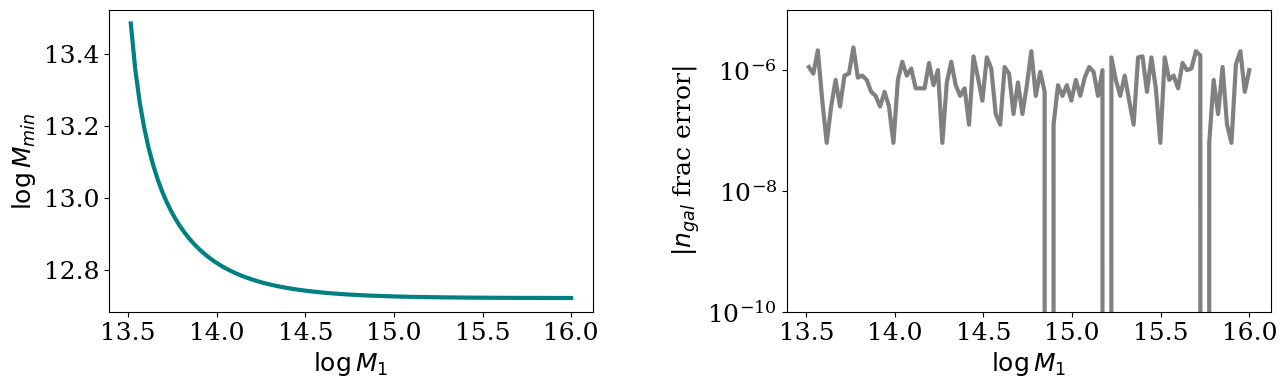

In [112]:
# plot iso-density curve and fractional error in galaxy number density

plt.rcParams.update({
    'lines.linewidth':3.0,
    'font.family':'serif',
    'font.size': 18,
    'legend.fontsize':16})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4), dpi=100)

ax1.plot(logM1_values, logMmin_values, color='teal')
ax1.set_xlabel(r'$\log\, M_1$')
ax1.set_ylabel(r'$\log\, M_{min}$')

ax2.plot(logM1_values, [np.abs(x - 0.001) / 0.001 for x in validation_n_gal], color='gray')
ax2.set_xlabel(r'$\log\, M_1$')
ax2.set_ylabel(r'$|n_{gal}$ frac error|')
ax2.set_yscale('log')
ax2.set_ylim([10**(-10), 10**(-5)])

fig.subplots_adjust(wspace=0.4, hspace=0.0)

plt.show()